In [1]:
from sys import path
from warnings import simplefilter

import numpy as np
import matplotlib.pyplot as plt

simplefilter("ignore")

OVERSAMPLING = 4 # psf
MAXITERS = 10 # psf construction
SIZE = 14 # in fwhm
MATCHING_KERNEL = 0.9 # aggressiveness

SN = 55.57033, -4.72181 # deg

CUTOUT_RADIUS = 15 # arcsec

IMAGE = "image.fits"
TEMPLATE = "template.fits"

In [2]:
from astropy.io import fits
from astropy.wcs import WCS
from astropy.stats import sigma_clipped_stats

img = type('', (), {})
with fits.open(IMAGE) as hdul:
    img.data = hdul[0].data.astype(np.float64)
    img.hdr = hdul[0].header
    img.wcs = WCS(img.hdr)
img.mean, img.median, img.std = sigma_clipped_stats(img.data, sigma=3.0)

tmp = type('', (), {})
with fits.open(TEMPLATE) as hdul:
    tmp.data = hdul[0].data.astype(np.float64)
    tmp.hdr = hdul[0].header
    tmp.wcs = WCS(tmp.hdr)
tmp.mean, tmp.median, tmp.std = sigma_clipped_stats(tmp.data, sigma=3.0)

In [3]:
from photutils import Background2D, SExtractorBackground
from astropy.stats import SigmaClip

img.background = Background2D(
        data = img.data,
        box_size = (128, 128),
        filter_size = (5, 5),
        sigma_clip = SigmaClip(sigma=3.0),
        bkg_estimator = SExtractorBackground(),
        exclude_percentile = 50.0
).background

tmp.background = Background2D(
        data = tmp.data,
        box_size = (128, 128),
        filter_size = (5, 5),
        sigma_clip = SigmaClip(sigma=3.0),
        bkg_estimator = SExtractorBackground(),
        exclude_percentile = 50.0
).background

In [4]:
from flows.coordinatematch import WCS2 as WCS
from photutils.detection import IRAFStarFinder

img.scale = WCS.from_astropy_wcs(img.wcs).scale
tmp.scale = WCS.from_astropy_wcs(tmp.wcs).scale

img.fwhm = 2 / img.scale
tmp.fwhm = 2 / tmp.scale

for i in range(10, 2, -1):
    for _ in range(3):
        img.sources = IRAFStarFinder(threshold=i*img.std, fwhm=img.fwhm)(img.data - img.background)
        if img.sources is None: break
        img.fwhm = sigma_clipped_stats(img.sources["fwhm"])[1]
    if not img.sources is None and len(img.sources) >= 3: break
else:
    raise Exception("Not enough stars in science image")

for i in range(10, 2, -1):
    for _ in range(3):
        tmp.sources = IRAFStarFinder(threshold=i*tmp.std, fwhm=tmp.fwhm)(tmp.data - tmp.background)
        if tmp.sources is None: break
        tmp.fwhm = sigma_clipped_stats(tmp.sources["fwhm"])[1]
    if not tmp.sources is None and len(tmp.sources) >= 3: break
else:
    raise Exception("Not enough stars in template image")

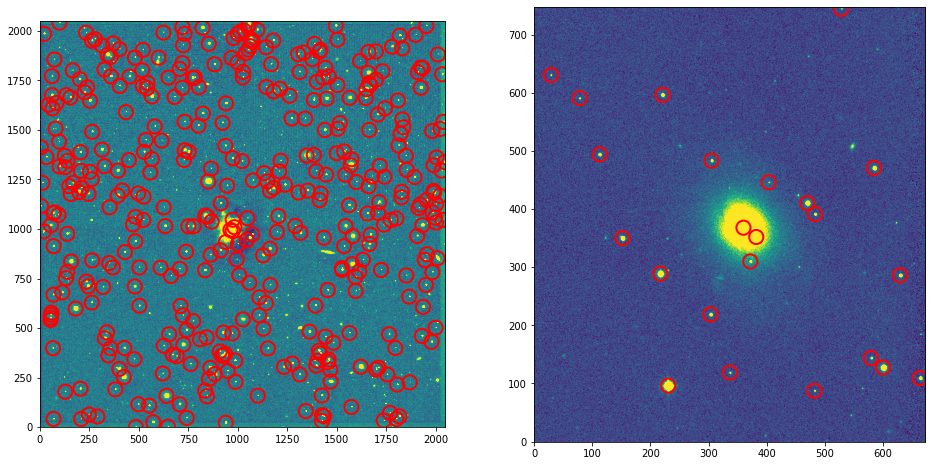

In [5]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 8))

clim = np.nanquantile(img.data - img.background, (.01, .99))
ax1.imshow(img.data - img.background, clim=clim, origin="lower")
ax1.scatter(*zip(*img.sources[["xcentroid", "ycentroid"]]), s=200, lw=2, edgecolor="red", facecolor="none")

clim = np.nanquantile(tmp.data - tmp.background, (.01, .99))
ax2.imshow(tmp.data - tmp.background, clim=clim, origin="lower")
ax2.scatter(*zip(*tmp.sources[["xcentroid", "ycentroid"]]), s=200, lw=2, edgecolor="red", facecolor="none")

In [6]:
from astropy.nddata import NDData
from astropy.table import Table
from photutils.psf import extract_stars

img.stars = extract_stars(
        NDData(data = img.data - img.background),
        Table(np.array(img.sources[["xcentroid", "ycentroid"]]), names=('x', 'y')),
        size = max(int(SIZE * img.fwhm + 1), 5) + 8
)

tmp.stars = extract_stars(
        NDData(data = tmp.data - tmp.background),
        Table(np.array(tmp.sources[["xcentroid", "ycentroid"]]), names=('x', 'y')),
        size = max(int(SIZE * tmp.fwhm + 1), 5) + 8
)

In [7]:
from flows.epsfbuilder import FlowsEPSFBuilder as EPSFBuilder
from photutils.psf import EPSFFitter

img.epsf, img.stars = EPSFBuilder(
        oversampling = OVERSAMPLING,
        shape = OVERSAMPLING * (max(SIZE * img.fwhm, 5) + 2),
        fitter = EPSFFitter(fit_boxsize = max(int(2 * img.fwhm + 1), 5)),
        recentering_boxsize = max(int(2 * img.fwhm + 1), 5),
        norm_radius = max(img.fwhm, 2.5),
        maxiters = MAXITERS,
        smoothing_kernel = None,
)(img.stars)
img.epsf._data = img.epsf._data[OVERSAMPLING:-OVERSAMPLING, OVERSAMPLING:-OVERSAMPLING]

print()

tmp.epsf, tmp.stars = EPSFBuilder(
        oversampling = OVERSAMPLING,
        shape = OVERSAMPLING * (max(SIZE * tmp.fwhm, 5) + 2),
        fitter = EPSFFitter(fit_boxsize = max(int(2 * tmp.fwhm + 1), 5)),
        recentering_boxsize = max(int(2 * tmp.fwhm + 1), 5),
        norm_radius = max(tmp.fwhm, 2.5),
        maxiters = MAXITERS,
        smoothing_kernel = None,
)(tmp.stars)
tmp.epsf._data = tmp.epsf._data[OVERSAMPLING:-OVERSAMPLING, OVERSAMPLING:-OVERSAMPLING]

PROGRESS: iteration 10 (of max 10) [12.6 s/iter]


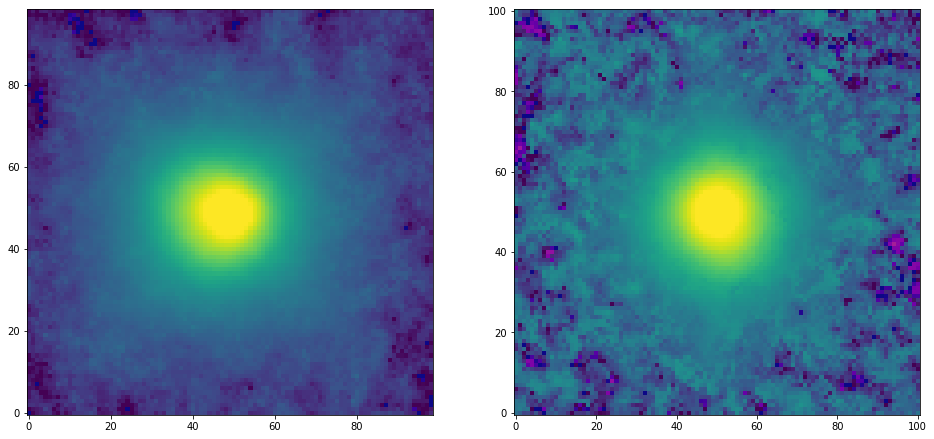

In [8]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 8))

clim = np.nanquantile(np.log(img.epsf.data), (.01, .99))
ax1.imshow(np.log(img.epsf.data), clim=clim, origin="lower")
ax1.imshow(np.log(-img.epsf.data), clim=clim, cmap="plasma", origin="lower")

clim = np.nanquantile(np.log(tmp.epsf.data), (.01, .99))
ax2.imshow(np.log(tmp.epsf.data), clim=clim, origin="lower")
ax2.imshow(np.log(-tmp.epsf.data), clim=clim, cmap="plasma", origin="lower")

In [9]:
img.data2 = img.data.copy()
tmp.data2 = tmp.data.copy()

In [10]:
from astropy.nddata import NDData
from astropy.table import Table
from photutils.psf import extract_stars
from photutils.psf import EPSFFitter

img.xy = np.array(img.sources[["xcentroid", "ycentroid"]].as_array().tolist())
tmp.xy = np.array(tmp.wcs.all_world2pix(img.wcs.all_pix2world(img.xy, 0), 0))

fitter = EPSFFitter(fit_boxsize = max(int(2 * img.fwhm + 1), 5))
img.stars2 = fitter(img.epsf, extract_stars(
        NDData(data = img.data - img.background),
        Table(img.xy, names=('x', 'y')),
        size = max(int(SIZE * img.fwhm + 1), 5) + 4
))

fitter = EPSFFitter(fit_boxsize = max(int(2 * tmp.fwhm + 1), 5))
tmp.stars2 = fitter(tmp.epsf, extract_stars(
        NDData(data = tmp.data - tmp.background),
        Table(tmp.xy, names=('x', 'y')),
        size = max(int(SIZE * tmp.fwhm + 1), 5) + 4
))

img.stars2 = {star.id_label: star for star in img.stars2}
tmp.stars2 = {star.id_label: star for star in tmp.stars2}

img.stars2, tmp.stars2 = zip(*[
        (img.stars2[i], tmp.stars2[i]) for i in set(img.stars2.keys()) & set(tmp.stars2.keys()) if
        not img.stars2[i]._excluded_from_fit and not tmp.stars2[i]._excluded_from_fit
])

In [11]:
from astropy.wcs.utils import fit_wcs_from_points
from astropy.coordinates import SkyCoord

xy = np.array(list(zip(*[star.center for star in tmp.stars2])))
rd = SkyCoord(img.wcs.all_pix2world([star.center for star in img.stars2], 0), unit="deg")
tmp.wcs = fit_wcs_from_points(xy, rd)

In [12]:
from reproject import reproject_interp

tmp2 = type('', (), {})

tmp2.data2, mask = reproject_interp((tmp.data2, tmp.wcs), img.hdr)
tmp2.wcs, mask = img.wcs, mask.astype(bool)
tmp2.mean, tmp2.median, tmp2.std = sigma_clipped_stats(tmp2.data2, sigma=3.0)

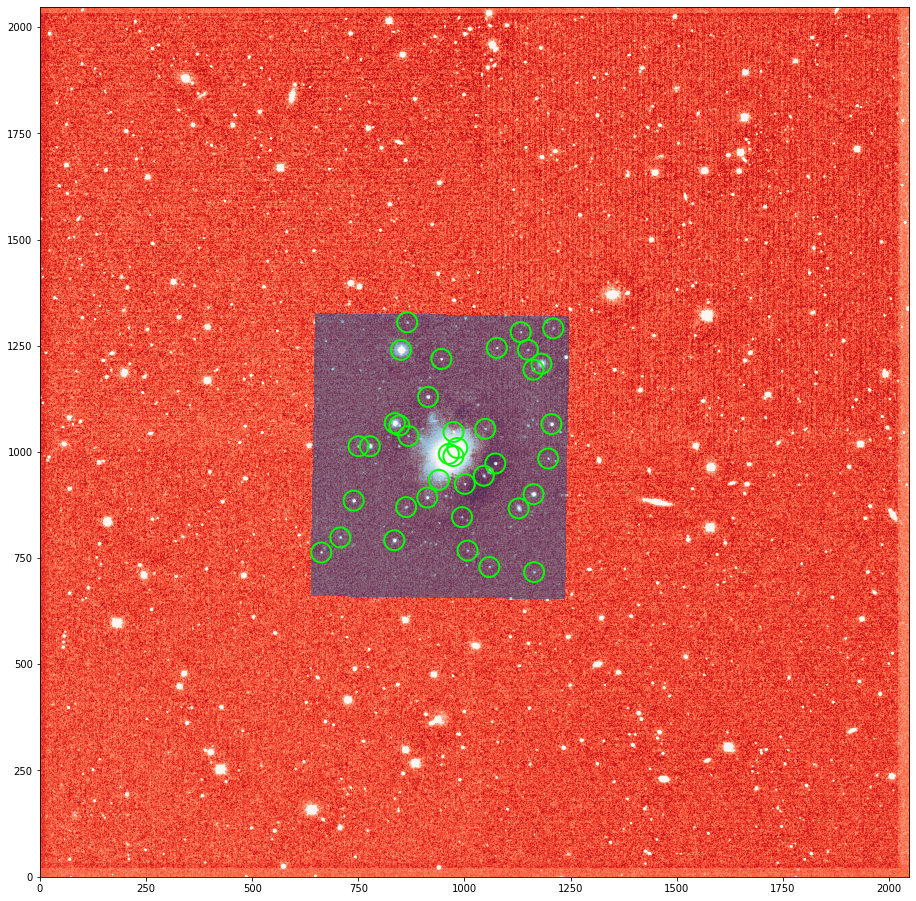

In [13]:
plt.figure(figsize=(16, 16))

clim = np.nanquantile(img.data2, (.01, .99))
plt.imshow(img.data2, clim=clim, cmap="Reds_r", origin="lower")

clim = np.nanquantile(tmp2.data2, (.01, .99))
plt.imshow(tmp2.data2, clim=clim, cmap="Blues_r", origin="lower", alpha=.5)

plt.scatter(*zip(*[star.center for star in img.stars2]), s=400, lw=2, edgecolor="lime", facecolor="none")

In [14]:
from photutils import Background2D, SExtractorBackground
from astropy.stats import SigmaClip

tmp2.background = Background2D(
        data = tmp2.data2,
        box_size = (128, 128),
        filter_size = (5, 5),
        sigma_clip = SigmaClip(sigma=3.0),
        bkg_estimator = SExtractorBackground(),
        exclude_percentile = 50.0
).background

In [15]:
from flows.coordinatematch import WCS2 as WCS
from photutils.detection import IRAFStarFinder

tmp2.fwhm = 2 / WCS.from_astropy_wcs(tmp2.wcs).scale
tmp2.fwhm *= 2

for i in range(10, 2, -1):
    for _ in range(3):
        tmp2.sources = IRAFStarFinder(threshold=i*tmp2.std, fwhm=tmp2.fwhm)(tmp2.data2 - tmp2.background)
        if tmp2.sources is None: break
        tmp2.fwhm = sigma_clipped_stats(tmp2.sources["fwhm"])[1]
    if not tmp2.sources is None and len(tmp2.sources) >= 3: break
else:
    raise Exception("Not enough stars in new template image")

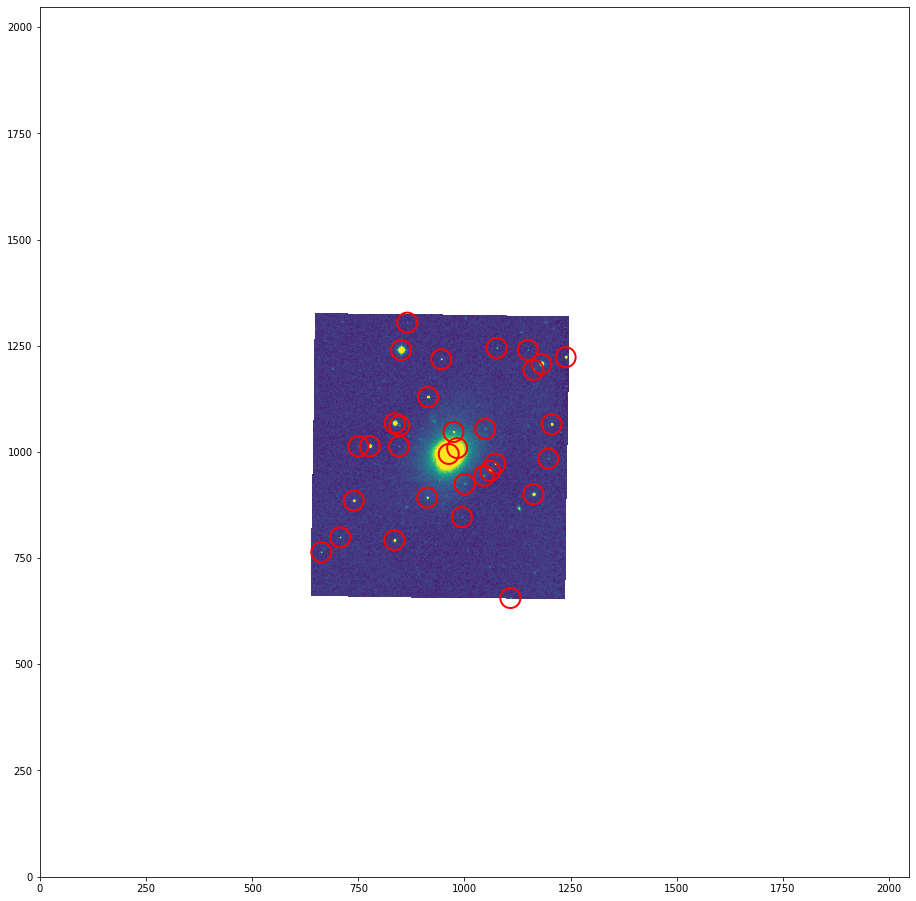

In [16]:
plt.figure(figsize=(16, 16))

clim = np.nanquantile(tmp2.data2 - tmp2.background, (.01, .99))
plt.imshow(tmp2.data2 - tmp2.background, clim=clim, origin="lower")
plt.scatter(*zip(*tmp2.sources[["xcentroid", "ycentroid"]]), s=400, lw=2, edgecolor="red", facecolor="none")

In [17]:
from astropy.nddata import NDData
from astropy.table import Table
from photutils.psf import extract_stars

tmp2.stars = extract_stars(
        NDData(data = tmp2.data2 - tmp2.background),
        Table(np.array(tmp2.sources[["xcentroid", "ycentroid"]]), names=('x', 'y')),
        size = (np.array(img.epsf.shape) - 1) / OVERSAMPLING + 2
)

In [18]:
from flows.epsfbuilder import FlowsEPSFBuilder as EPSFBuilder
from photutils.psf import EPSFFitter

tmp2.epsf, tmp2.stars = EPSFBuilder(
        oversampling = OVERSAMPLING,
        shape = img.epsf.shape,
        fitter = EPSFFitter(fit_boxsize = max(int(2 * tmp2.fwhm + 1), 5)),
        recentering_boxsize = max(int(2 * tmp2.fwhm + 1), 5),
        norm_radius = max(tmp2.fwhm, 2.5),
        maxiters = MAXITERS,
        smoothing_kernel = None,
)(tmp2.stars)
tmp2.epsf._data = tmp2.epsf.data[OVERSAMPLING:-OVERSAMPLING, OVERSAMPLING:-OVERSAMPLING]

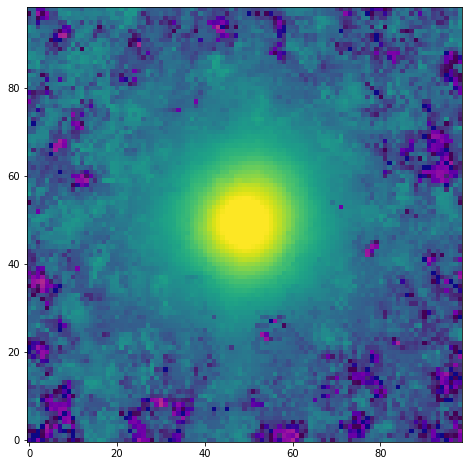

In [19]:
plt.figure(figsize=(8, 8))
clim = np.nanquantile(np.log(tmp2.epsf.data), (.01, .99))
plt.imshow(np.log(tmp2.epsf.data), clim=clim, origin="lower")
plt.imshow(np.log(-tmp2.epsf.data), clim=clim, cmap="plasma", origin="lower")

In [20]:
from astropy.nddata import NDData
from astropy.table import Table
from photutils.psf import extract_stars

xy = np.array(img.sources[["xcentroid", "ycentroid"]].as_array().tolist())

i = xy.round().astype(int)
xy = xy[mask[i[:,1], i[:,0]]]

fitter = EPSFFitter(fit_boxsize = max(int(2 * img.fwhm + 1), 5))
img.stars3 = fitter(img.epsf, extract_stars(
        NDData(data = img.data2 - img.background),
        Table(xy, names=('x', 'y')),
        size = max(int(SIZE * img.fwhm + 1), 5) + 4
))

fitter = EPSFFitter(fit_boxsize = max(int(2 * tmp2.fwhm + 1), 5))
tmp2.stars3 = fitter(tmp2.epsf, extract_stars(
        NDData(data = tmp2.data2 - tmp2.background),
        Table(xy, names=('x', 'y')),
        size = max(int(SIZE * tmp2.fwhm + 1), 5) + 4
))

img.stars3  = {star.id_label: star for star in img.stars3}
tmp2.stars3 = {star.id_label: star for star in tmp2.stars3}

In [21]:
from scipy.spatial import ConvexHull, convex_hull_plot_2d
from PIL import Image, ImageDraw

data = tmp2.data2.copy()
mask2 = mask.copy()
mask3 = mask.copy()

i_stars = [i for i in set(img.stars3.keys()) & set(tmp2.stars3.keys()) if
        not img.stars3[i]._excluded_from_fit and not tmp2.stars3[i]._excluded_from_fit
]

X, Y = np.meshgrid(*map(np.arange, img.data.shape[::-1]))
for x, y in xy:
    i = np.where((X - x)**2 + (Y - y)**2 < (10*2.5 * img.fwhm)**2)
    mask2[i] = False

hull = ConvexHull(xy)
polygon = list(map(tuple, np.round(hull.points[hull.vertices]).astype(int)))

m = Image.new('L', mask3.shape[::-1], 0)
ImageDraw.Draw(m).polygon(polygon, outline=1, fill=1)
mask3 *= np.array(m).astype(bool)

data -= np.nanquantile(tmp2.data2[mask2*mask3], .25)
data /= np.nanmedian([tmp2.stars3[i].flux / img.stars3[i].flux for i in i_stars])
data += np.nanquantile(img.data2[mask2*mask3], .25)

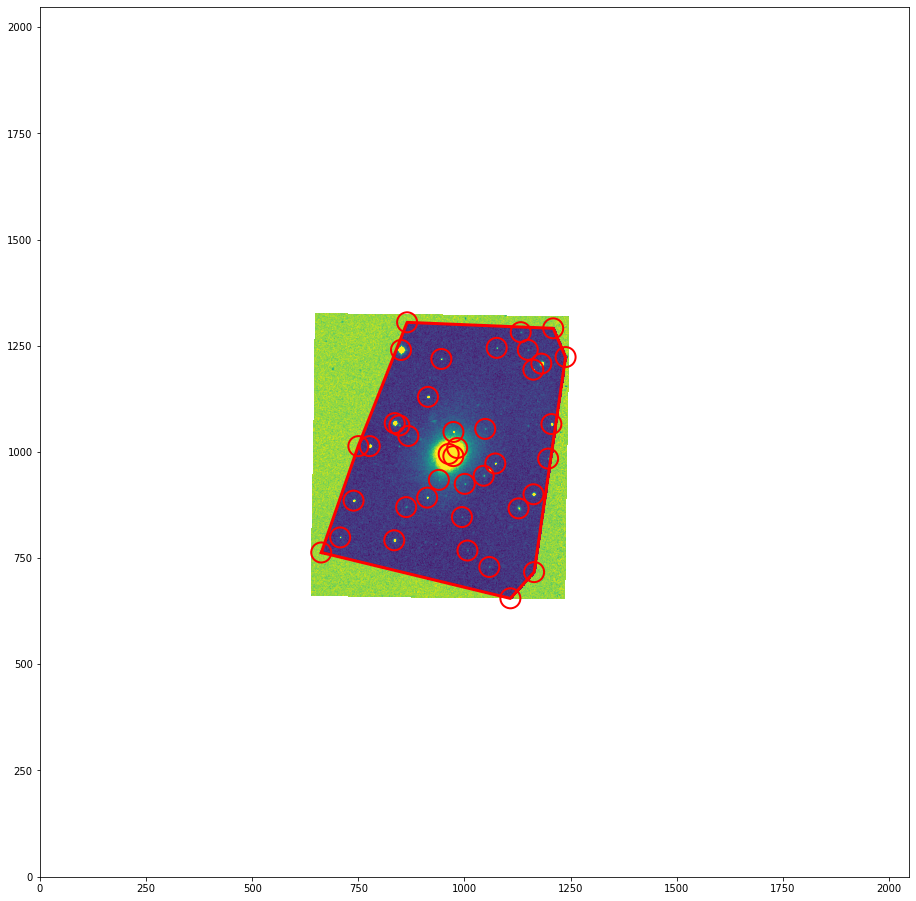

In [22]:
plt.figure(figsize=(16, 16))

clim = np.nanquantile(data, (.01, .99))
plt.imshow(data, clim=clim, origin="lower")
_data = data.copy()
_data[mask3] = np.nan
plt.imshow(_data, clim=clim, cmap="viridis_r", origin="lower")

plt.scatter(*zip(*xy), s=400, lw=2, edgecolor="red", facecolor="none")
plt.plot(*zip(*polygon + [polygon[0]]), lw=3, color="red")

plt.show()

In [23]:
from photutils import create_matching_kernel, CosineBellWindow
from astropy.convolution import convolve_fft

s = len(img.epsf.data) / OVERSAMPLING
t = np.arange(s) - s // 2
x, y = np.meshgrid(t, t)

matching_kernel = create_matching_kernel(
        source_psf = tmp2.epsf.evaluate(x, y, 1, 0, 0),
        target_psf = img.epsf.evaluate(x, y, 1, 0, 0),
        window = CosineBellWindow(MATCHING_KERNEL)
)
data = convolve_fft(data, matching_kernel)

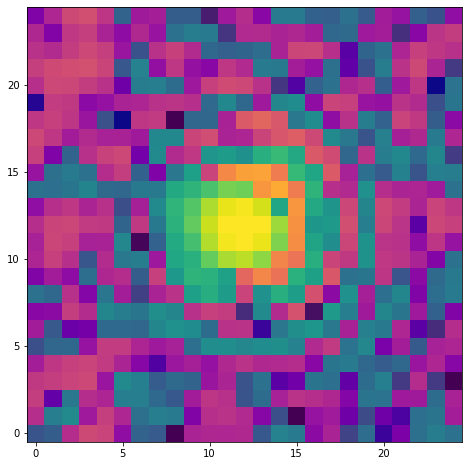

In [24]:
plt.figure(figsize=(8, 8))
clim = np.nanquantile(np.log(matching_kernel), (.01, .99))
plt.imshow(np.log(matching_kernel), clim=clim, origin="lower")
plt.imshow(np.log(-matching_kernel), clim=clim, cmap="plasma", origin="lower")

In [25]:
X, Y = np.meshgrid(*map(np.arange, img.data.shape[::-1]))
data2 = img.data2.copy()

x, y = img.wcs.all_world2pix(*SN, 0)
i = np.where((X - x)**2 + (Y - y)**2 < (CUTOUT_RADIUS / img.scale)**2)
data2[i] -= data[i]

(765.3383594224625, 1211.2057265267233)

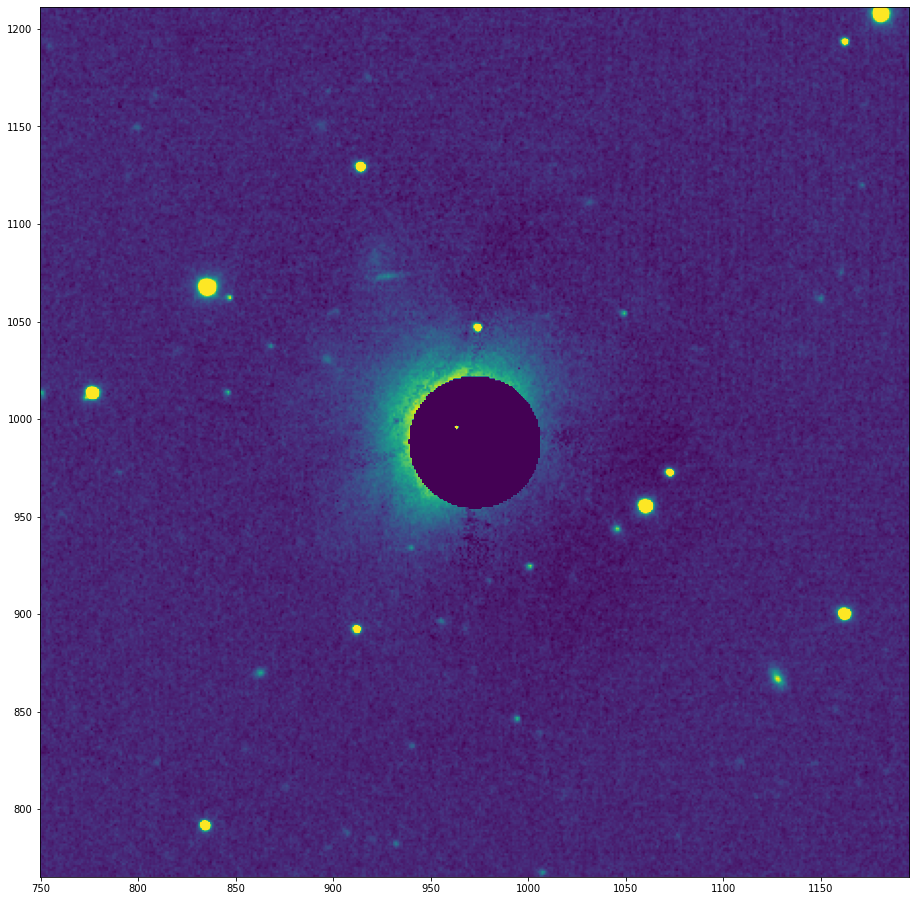

In [26]:
plt.figure(figsize=(16, 16))
clim = np.nanquantile(data2, (.001, .999))
plt.imshow(data2, clim=clim, origin="lower")
x, y = img.wcs.all_world2pix(*SN, 0)
plt.xlim(x - 100 / img.scale, x + 100 / img.scale)
plt.ylim(y - 100 / img.scale, y + 100 / img.scale)

In [ ]:
filename, ext = IMAGE[:IMAGE.index(".fits")], IMAGE[IMAGE.index(".fits"):]
filename = "/subtracted/".join(filename.rsplit('/', 1)) + ".diff" + ext

with fits.open(IMAGE) as hdul:

    hdul[0].header["FWHM"] = img.fwhm
    hdul[0].header["SCALE"] = img.scale

    hdul[0].data = data2

    hdul.writeto(filename, overwrite=True)

print(filename)